<a href="https://colab.research.google.com/github/grace3999/USV_Python/blob/colab/Notebooks/%E2%80%A24_xr_Annotations_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#mount google drive containings required files: 1) csv of annotation features, 2) netcdf files
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
!pip install netcdf4

In [0]:
!pip install seaborn==0.9.0

In [0]:
import numpy as np
import pandas as pd
import xarray as xr
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, cross_val_predict, GroupKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC  
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.dummy import DummyClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score
from sklearn.utils import resample

#visualizing results
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import warnings; warnings.simplefilter('ignore')
np.set_printoptions(suppress=True)

In [0]:
features_path_pain = '/content/gdrive/Team Drives/USV_eScience_Incubator/Data/feature_data_frames/annot_psd_100noise_pain.csv'
features_path_pairing = '/content/gdrive/Team Drives/USV_eScience_Incubator/Data/feature_data_frames/annot_psd_100noise_fear.csv'
features_path = [features_path_pain, features_path_pairing]

In [0]:
annot_features_df = pd.DataFrame()

#Read in data frame of annotation features
for path in features_path:
  data = pd.read_csv(path)
  annot_features = pd.DataFrame(data = data)
  print(annot_features.shape)
  #check for missing values
  if annot_features.isnull().sum().sum() > 0:
    print('You have missing values in your data frame')
  else:
    print('Your data frame is complete')
  
  annot_features_df = annot_features_df.append(annot_features)

annot_features_df.replace('BBC', 'bbc', inplace=True)
print(annot_features_df.shape)
annot_features_df.head()

(1978, 262)
Your data frame is complete
(1759, 262)
Your data frame is complete
(3737, 262)


,Unnamed: 0,animal_number,session,time_stamp,Annotation,0.0,0.48828125,0.9765625,1.46484375,1.953125,2.44140625,2.9296875,3.41796875,3.90625,4.39453125,4.8828125,5.37109375,5.859375,6.34765625,6.8359375,7.32421875,7.8125,8.30078125,8.7890625,9.27734375,9.765625,10.25390625,10.7421875,11.23046875,11.71875,12.20703125,12.6953125,13.18359375,13.671875,14.16015625,14.6484375,15.13671875,15.625,16.11328125,16.6015625,17.08984375,17.578125,18.06640625,18.5546875,19.04296875,19.53125,20.01953125,20.5078125,20.99609375,21.484375,21.97265625,22.4609375,22.94921875,23.4375,23.92578125,24.4140625,24.90234375,25.390625,25.87890625,26.3671875,26.85546875,27.34375,27.83203125,28.3203125,28.80859375,29.296875,29.78515625,30.2734375,30.76171875,31.25,31.73828125,32.2265625,32.71484375,33.203125,33.69140625,34.1796875,34.66796875,35.15625,35.64453125,36.1328125,36.62109375,37.109375,37.59765625,38.0859375,38.57421875,39.0625,39.55078125,40.0390625,40.52734375,41.015625,41.50390625,41.9921875,42.48046875,42.96875,43.45703125,43.9453125,44.43359375,44.921875,45.41015625,45.8984375,46.38671875,46.875,47.36328125,47.8515625,48.33984375,48.828125,49.31640625,49.8046875,50.29296875,50.78125,51.26953125,51.7578125,52.24609375,52.734375,53.22265625,53.7109375,54.19921875,54.6875,55.17578125,55.6640625,56.15234375,56.640625,57.12890625,57.6171875,58.10546875,58.59375,59.08203125,59.5703125,60.05859375,60.546875,61.03515625,61.5234375,62.01171875,62.5,62.98828125,63.4765625,63.96484375,64.453125,64.94140625,65.4296875,65.91796875,66.40625,66.89453125,67.3828125,67.87109375,68.359375,68.84765625,69.3359375,69.82421875,70.3125,70.80078125,71.2890625,71.77734375,72.265625,72.75390625,73.2421875,73.73046875,74.21875,74.70703125,75.1953125,75.68359375,76.171875,76.66015625,77.1484375,77.63671875,78.125,78.61328125,79.1015625,79.58984375,80.078125,80.56640625,81.0546875,81.54296875,82.03125,82.51953125,83.0078125,83.49609375,83.984375,84.47265625,84.9609375,85.44921875,85.9375,86.42578125,86.9140625,87.40234375,87.890625,88.37890625,88.8671875,89.35546875,89.84375,90.33203125,90.8203125,91.30859375,91.796875,92.28515625,92.7734375,93.26171875,93.75,94.23828125,94.7265625,95.21484375,95.703125,96.19140625,96.6796875,97.16796875,97.65625,98.14453125,98.6328125,99.12109375,99.609375,100.09765625,100.5859375,101.07421875,101.5625,102.05078125,102.5390625,103.02734375,103.515625,104.00390625,104.4921875,104.98046875,105.46875,105.95703125,106.4453125,106.93359375,107.421875,107.91015625,108.3984375,108.88671875,109.375,109.86328125,110.3515625,110.83984375,111.328125,111.81640625,112.3046875,112.79296875,113.28125,113.76953125,114.2578125,114.74609375,115.234375,115.72265625,116.2109375,116.69921875,117.1875,117.67578125,118.1640625,118.65234375,119.140625,119.62890625,120.1171875,120.60546875,121.09375,121.58203125,122.0703125,122.55859375,123.046875,123.53515625,124.0234375,124.51171875,125.0
0,0,A2,D2,32692.5,bbc,13.637799,32.029465,40.756600,46.423640,54.857754,81.108800,129.673570,185.002700,228.132830,260.974060,306.68338,382.00436,472.138280,537.11570,543.29724,488.26282,399.12200,312.56866,255.48404,235.16531,240.43390,255.00000,277.16757,325.34003,413.93115,519.36970,581.25760,554.19464,462.56094,391.66300,410.98727,504.61246,584.26807,574.37230,481.63390,380.90582,339.31473,359.97034,395.59558,405.45087,391.93120,386.23645,408.48474,446.31067,468.01187,450.56525,395.27103,322.57950,256.52880,211.90110,189.67651,180.45277,172.88970,161.43845,147.25041,132.73064,117.89231,103.849335,97.032166,104.26331,122.02371,135.76566,135.64865,131.93623,148.41763,196.98897,261.275180,308.53827,316.64197,287.82578,240.58875,195.70609,169.90140,171.60716,192.06667,204.13176,184.21303,142.88310,125.07376,166.67340,249.88919,312.53543,308.53003,253.85197,205.60132,199.82014,220.24948,228.12936,208.99100,180.130130,160.156220,147.871640,135.06740,126.958860,137.33174,166.155010,193.213640,197.68645,178.050870,148.74963,122.148170,99.917110,80.09541,64.891250,58.050888,58.3

In [0]:
x = annot_features_df[annot_features_df['animal_number'] == 'A2']
x = x[x['session'] == 'D2']
x[x['Annotation'] == 'bbc']

,Unnamed: 0,animal_number,session,time_stamp,Annotation,0.0,0.48828125,0.9765625,1.46484375,1.953125,2.44140625,2.9296875,3.41796875,3.90625,4.39453125,4.8828125,5.37109375,5.859375,6.34765625,6.8359375,7.32421875,7.8125,8.30078125,8.7890625,9.27734375,9.765625,10.25390625,10.7421875,11.23046875,11.71875,12.20703125,12.6953125,13.18359375,13.671875,14.16015625,14.6484375,15.13671875,15.625,16.11328125,16.6015625,17.08984375,17.578125,18.06640625,18.5546875,19.04296875,19.53125,20.01953125,20.5078125,20.99609375,21.484375,21.97265625,22.4609375,22.94921875,23.4375,23.92578125,24.4140625,24.90234375,25.390625,25.87890625,26.3671875,26.85546875,27.34375,27.83203125,28.3203125,28.80859375,29.296875,29.78515625,30.2734375,30.76171875,31.25,31.73828125,32.2265625,32.71484375,33.203125,33.69140625,34.1796875,34.66796875,35.15625,35.64453125,36.1328125,36.62109375,37.109375,37.59765625,38.0859375,38.57421875,39.0625,39.55078125,40.0390625,40.52734375,41.015625,41.50390625,41.9921875,42.48046875,42.96875,43.45703125,43.9453125,44.43359375,44.921875,45.41015625,45.8984375,46.38671875,46.875,47.36328125,47.8515625,48.33984375,48.828125,49.31640625,49.8046875,50.29296875,50.78125,51.26953125,51.7578125,52.24609375,52.734375,53.22265625,53.7109375,54.19921875,54.6875,55.17578125,55.6640625,56.15234375,56.640625,57.12890625,57.6171875,58.10546875,58.59375,59.08203125,59.5703125,60.05859375,60.546875,61.03515625,61.5234375,62.01171875,62.5,62.98828125,63.4765625,63.96484375,64.453125,64.94140625,65.4296875,65.91796875,66.40625,66.89453125,67.3828125,67.87109375,68.359375,68.84765625,69.3359375,69.82421875,70.3125,70.80078125,71.2890625,71.77734375,72.265625,72.75390625,73.2421875,73.73046875,74.21875,74.70703125,75.1953125,75.68359375,76.171875,76.66015625,77.1484375,77.63671875,78.125,78.61328125,79.1015625,79.58984375,80.078125,80.56640625,81.0546875,81.54296875,82.03125,82.51953125,83.0078125,83.49609375,83.984375,84.47265625,84.9609375,85.44921875,85.9375,86.42578125,86.9140625,87.40234375,87.890625,88.37890625,88.8671875,89.35546875,89.84375,90.33203125,90.8203125,91.30859375,91.796875,92.28515625,92.7734375,93.26171875,93.75,94.23828125,94.7265625,95.21484375,95.703125,96.19140625,96.6796875,97.16796875,97.65625,98.14453125,98.6328125,99.12109375,99.609375,100.09765625,100.5859375,101.07421875,101.5625,102.05078125,102.5390625,103.02734375,103.515625,104.00390625,104.4921875,104.98046875,105.46875,105.95703125,106.4453125,106.93359375,107.421875,107.91015625,108.3984375,108.88671875,109.375,109.86328125,110.3515625,110.83984375,111.328125,111.81640625,112.3046875,112.79296875,113.28125,113.76953125,114.2578125,114.74609375,115.234375,115.72265625,116.2109375,116.69921875,117.1875,117.67578125,118.1640625,118.65234375,119.140625,119.62890625,120.1171875,120.60546875,121.09375,121.58203125,122.0703125,122.55859375,123.046875,123.53515625,124.0234375,124.51171875,125.0
0,0,A2,D2,32692.5,bbc,13.637799,32.029465,40.756600,46.423640,54.857754,81.108800,129.673570,185.002700,228.132830,260.974060,306.68338,382.00436,472.138280,537.11570,543.29724,488.26282,399.12200,312.56866,255.48404,235.16531,240.43390,255.00000,277.16757,325.34003,413.93115,519.36970,581.25760,554.19464,462.56094,391.66300,410.98727,504.61246,584.26807,574.37230,481.63390,380.90582,339.31473,359.97034,395.59558,405.45087,391.93120,386.23645,408.48474,446.31067,468.01187,450.56525,395.27103,322.57950,256.52880,211.90110,189.67651,180.45277,172.88970,161.43845,147.25041,132.73064,117.89231,103.849335,97.032166,104.26331,122.02371,135.76566,135.64865,131.93623,148.41763,196.98897,261.275180,308.53827,316.64197,287.82578,240.58875,195.70609,169.90140,171.60716,192.06667,204.13176,184.21303,142.88310,125.07376,166.67340,249.88919,312.53543,308.53003,253.85197,205.60132,199.82014,220.24948,228.12936,208.99100,180.130130,160.156220,147.871640,135.06740,126.958860,137.33174,166.155010,193.213640,197.68645,178.050870,148.74963,122.148170,99.917110,80.09541,64.891250,58.050888,58.3

In [0]:
annot_features_df.groupby('Annotation').describe()

0.0                                                                                   0.48828125                                                                                    0.9765625                                                                                   1.46484375                                                                                    1.953125                                                                                    10.25390625                                                                                               10.7421875                                                                                              100.09765625                                                                                100.5859375                                                                                101.07421875                                                                                101.5625                         \
            count        mean         std        min        25%         50%         75%         max      count        mean         std        min         25%         50%         75%         max     count        mean         std        min         25%         50%         75%        max      count        mean         std        min         25%         50%         75%         max    count        mean         std        min         25%         50%         75%         max       count          mean           std         min          25%           50%           75%          max      count          mean           std         min          25%          50%           75%          max        count       mean         std        min        25%        50%        75%         max       count       mean         std        min        25%        50%        75%         max        count       mean         std        min        25%        50%        75%         max    count       mean         std   
Annotation                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
bbc         223.0   17.236102   20.717203   1.940417   5.174689    8.878462   22.786537   172.74606      223.0   41.902930   49.378586   4.876487   11.129086   18.948896   50.125929   302.33350     223.0   59.913846   87.277680   6.349554   13.166572   20.794874   47.074303   465.1402      223.0   81.361426  136.030581   7.716131   15.508676   23.726542   47.251410   708.22076    223.0  105.052490  182.007298  10.661650   19.028369   27.455868   57.642584   801.53530       223.0    498.158831    731.340489   55.975803   147.635010    303.726650    506.703850    6196.0024      223.0    500.280379    692.534559   57.003960   160.768585   293.359600    521.136470    6161.6045        223.0  48.619840   15.658833  26.828468  39.649321  44.418262  50.770118  158.965840       223.0  48.423142   16.145930  29.317848  40.123309  44.677135  50.183215  182.548050        223.0  48.042960   15.923317  27.339660  39.515369  43.816776  50.589867  190.900900    223.0  47.859292   14.927530   
high multi    4.0   36.768639   10.080521  28.

In [0]:
def annotations_to_classes_df(dataframe, annot_dic):
  """takes in dataframe of computed slice features and a dictonary containing the annotation classes as keys and 
  annotation names as values (you will need to create this) and generates a new dataframe specific to the dic"""

  i = 0
  annot_features_classes = pd.DataFrame()
  while i < len(annot_dic):
    annot_df = dataframe[dataframe['Annotation'] == annot_dic[i]]
    annot_df['class'] = i
    annot_features_classes = pd.concat([annot_features_classes, annot_df], axis = 0)
    i = i + 1
    
  return annot_features_classes
                         

In [0]:
#create dictionary containing annotation types and corresponding class variable that you wish to use for model generation
annot_dic = {0: 'rand_noise', 1: 'bbc'}

annot_features_classes = annotations_to_classes_df(annot_features_df, annot_dic)
print(annot_features_classes.shape)
print(annot_features_classes['Annotation'].value_counts())
annot_features_classes.head()

(3623, 263)
rand_noise    3400
bbc            223
Name: Annotation, dtype: int64


,Unnamed: 0,animal_number,session,time_stamp,Annotation,0.0,0.48828125,0.9765625,1.46484375,1.953125,2.44140625,2.9296875,3.41796875,3.90625,4.39453125,4.8828125,5.37109375,5.859375,6.34765625,6.8359375,7.32421875,7.8125,8.30078125,8.7890625,9.27734375,9.765625,10.25390625,10.7421875,11.23046875,11.71875,12.20703125,12.6953125,13.18359375,13.671875,14.16015625,14.6484375,15.13671875,15.625,16.11328125,16.6015625,17.08984375,17.578125,18.06640625,18.5546875,19.04296875,19.53125,20.01953125,20.5078125,20.99609375,21.484375,21.97265625,22.4609375,22.94921875,23.4375,23.92578125,24.4140625,24.90234375,25.390625,25.87890625,26.3671875,26.85546875,27.34375,27.83203125,28.3203125,28.80859375,29.296875,29.78515625,30.2734375,30.76171875,31.25,31.73828125,32.2265625,32.71484375,33.203125,33.69140625,34.1796875,34.66796875,35.15625,35.64453125,36.1328125,36.62109375,37.109375,37.59765625,38.0859375,38.57421875,39.0625,39.55078125,40.0390625,40.52734375,41.015625,41.50390625,41.9921875,42.48046875,42.96875,43.45703125,43.9453125,44.43359375,44.921875,45.41015625,45.8984375,46.38671875,46.875,47.36328125,47.8515625,48.33984375,48.828125,49.31640625,49.8046875,50.29296875,50.78125,51.26953125,51.7578125,52.24609375,52.734375,53.22265625,53.7109375,54.19921875,54.6875,55.17578125,55.6640625,56.15234375,56.640625,57.12890625,57.6171875,58.10546875,58.59375,59.08203125,59.5703125,60.05859375,60.546875,61.03515625,61.5234375,62.01171875,62.5,62.98828125,63.4765625,63.96484375,64.453125,64.94140625,65.4296875,65.91796875,66.40625,66.89453125,67.3828125,67.87109375,68.359375,68.84765625,69.3359375,69.82421875,70.3125,70.80078125,71.2890625,71.77734375,72.265625,72.75390625,73.2421875,73.73046875,74.21875,74.70703125,75.1953125,75.68359375,76.171875,76.66015625,77.1484375,77.63671875,78.125,78.61328125,79.1015625,79.58984375,80.078125,80.56640625,81.0546875,81.54296875,82.03125,82.51953125,83.0078125,83.49609375,83.984375,84.47265625,84.9609375,85.44921875,85.9375,86.42578125,86.9140625,87.40234375,87.890625,88.37890625,88.8671875,89.35546875,89.84375,90.33203125,90.8203125,91.30859375,91.796875,92.28515625,92.7734375,93.26171875,93.75,94.23828125,94.7265625,95.21484375,95.703125,96.19140625,96.6796875,97.16796875,97.65625,98.14453125,98.6328125,99.12109375,99.609375,100.09765625,100.5859375,101.07421875,101.5625,102.05078125,102.5390625,103.02734375,103.515625,104.00390625,104.4921875,104.98046875,105.46875,105.95703125,106.4453125,106.93359375,107.421875,107.91015625,108.3984375,108.88671875,109.375,109.86328125,110.3515625,110.83984375,111.328125,111.81640625,112.3046875,112.79296875,113.28125,113.76953125,114.2578125,114.74609375,115.234375,115.72265625,116.2109375,116.69921875,117.1875,117.67578125,118.1640625,118.65234375,119.140625,119.62890625,120.1171875,120.60546875,121.09375,121.58203125,122.0703125,122.55859375,123.046875,123.53515625,124.0234375,124.51171875,125.0,class
178,0,A2,D2,145597.5,rand_noise,35.563732,82.162830,102.763760,113.473930,116.165070,132.153900,174.249000,236.314100,317.73712,441.686520,623.977300,821.005900,936.260400,909.36630,801.33970,766.77100,917.26215,1207.56700,1464.29500,1534.19780,1412.919900,1243.288000,1197.58630,1349.34840,1631.80130,1906.00790,2081.37620,2187.24560,2323.37670,2524.37480,2676.08800,2595.57370,2219.36500,1706.26490,1326.84330,1234.37160,1344.99370,1441.39690,1381.55070,1202.27280,1041.08230,988.05334,1019.60223,1050.20640,1019.83075,929.38916,813.48553,699.51184,595.78220,507.11320,446.89470,425.46630,429.02010,420.960270,374.199860,301.92413,247.917270,241.40636,265.681430,276.789180,250.42746,203.226500,167.943530,156.72580,154.847690,145.072570,128.03601,116.63725,117.727806,125.422210,130.085710,127.960610,120.864780,110.784530,98.229416,84.686910,73.516884,67.333340,65.592964,65.539375,65.018400,63.816074,62.626686,61.534428,59.880203,57.400555,55.043854,54.271946,55.465103,57.348526,58.36734,58.411453,58.500595,58.658897,57.081528,52.390560,46.318893,42.773080,43.712300,46.977867

In [0]:
annot_features_df['class'] = annot_features_df['Annotation'].replace({'rand_noise': 0, 'bbc': 1, 'high multi': 1, 'high slug': 1, 'low multi': 1, 'low slug': 1})
print(annot_features_df['class'].value_counts())
annot_features_df.head()

0    510
1    337
Name: class, dtype: int64


,Unnamed: 0,animal_number,session,time_stamp,Annotation,0.0,0.48828125,0.9765625,1.46484375,1.953125,2.44140625,2.9296875,3.41796875,3.90625,4.39453125,4.8828125,5.37109375,5.859375,6.34765625,6.8359375,7.32421875,7.8125,8.30078125,8.7890625,9.27734375,9.765625,10.25390625,10.7421875,11.23046875,11.71875,12.20703125,12.6953125,13.18359375,13.671875,14.16015625,14.6484375,15.13671875,15.625,16.11328125,16.6015625,17.08984375,17.578125,18.06640625,18.5546875,19.04296875,19.53125,20.01953125,20.5078125,20.99609375,21.484375,21.97265625,22.4609375,22.94921875,23.4375,23.92578125,24.4140625,24.90234375,25.390625,25.87890625,26.3671875,26.85546875,27.34375,27.83203125,28.3203125,28.80859375,29.296875,29.78515625,30.2734375,30.76171875,31.25,31.73828125,32.2265625,32.71484375,33.203125,33.69140625,34.1796875,34.66796875,35.15625,35.64453125,36.1328125,36.62109375,37.109375,37.59765625,38.0859375,38.57421875,39.0625,39.55078125,40.0390625,40.52734375,41.015625,41.50390625,41.9921875,42.48046875,42.96875,43.45703125,43.9453125,44.43359375,44.921875,45.41015625,45.8984375,46.38671875,46.875,47.36328125,47.8515625,48.33984375,48.828125,49.31640625,49.8046875,50.29296875,50.78125,51.26953125,51.7578125,52.24609375,52.734375,53.22265625,53.7109375,54.19921875,54.6875,55.17578125,55.6640625,56.15234375,56.640625,57.12890625,57.6171875,58.10546875,58.59375,59.08203125,59.5703125,60.05859375,60.546875,61.03515625,61.5234375,62.01171875,62.5,62.98828125,63.4765625,63.96484375,64.453125,64.94140625,65.4296875,65.91796875,66.40625,66.89453125,67.3828125,67.87109375,68.359375,68.84765625,69.3359375,69.82421875,70.3125,70.80078125,71.2890625,71.77734375,72.265625,72.75390625,73.2421875,73.73046875,74.21875,74.70703125,75.1953125,75.68359375,76.171875,76.66015625,77.1484375,77.63671875,78.125,78.61328125,79.1015625,79.58984375,80.078125,80.56640625,81.0546875,81.54296875,82.03125,82.51953125,83.0078125,83.49609375,83.984375,84.47265625,84.9609375,85.44921875,85.9375,86.42578125,86.9140625,87.40234375,87.890625,88.37890625,88.8671875,89.35546875,89.84375,90.33203125,90.8203125,91.30859375,91.796875,92.28515625,92.7734375,93.26171875,93.75,94.23828125,94.7265625,95.21484375,95.703125,96.19140625,96.6796875,97.16796875,97.65625,98.14453125,98.6328125,99.12109375,99.609375,100.09765625,100.5859375,101.07421875,101.5625,102.05078125,102.5390625,103.02734375,103.515625,104.00390625,104.4921875,104.98046875,105.46875,105.95703125,106.4453125,106.93359375,107.421875,107.91015625,108.3984375,108.88671875,109.375,109.86328125,110.3515625,110.83984375,111.328125,111.81640625,112.3046875,112.79296875,113.28125,113.76953125,114.2578125,114.74609375,115.234375,115.72265625,116.2109375,116.69921875,117.1875,117.67578125,118.1640625,118.65234375,119.140625,119.62890625,120.1171875,120.60546875,121.09375,121.58203125,122.0703125,122.55859375,123.046875,123.53515625,124.0234375,124.51171875,125.0,class
0,0,A2,D2,32692.5,bbc,13.637799,32.029465,40.756600,46.423640,54.857754,81.108800,129.673570,185.002700,228.132830,260.974060,306.68338,382.00436,472.138280,537.11570,543.29724,488.26282,399.12200,312.56866,255.48404,235.16531,240.43390,255.00000,277.16757,325.34003,413.93115,519.36970,581.25760,554.19464,462.56094,391.66300,410.98727,504.61246,584.26807,574.37230,481.63390,380.90582,339.31473,359.97034,395.59558,405.45087,391.93120,386.23645,408.48474,446.31067,468.01187,450.56525,395.27103,322.57950,256.52880,211.90110,189.67651,180.45277,172.88970,161.43845,147.25041,132.73064,117.89231,103.849335,97.032166,104.26331,122.02371,135.76566,135.64865,131.93623,148.41763,196.98897,261.275180,308.53827,316.64197,287.82578,240.58875,195.70609,169.90140,171.60716,192.06667,204.13176,184.21303,142.88310,125.07376,166.67340,249.88919,312.53543,308.53003,253.85197,205.60132,199.82014,220.24948,228.12936,208.99100,180.130130,160.156220,147.871640,135.06740,126.958860,137.33174,166.155010,193.213640,197.68645,178.050870,148.74963,122.148170,99.917110,80.09541,64.891250,58.05088

In [0]:
#separate and save for later testing dataset
train, test = train_test_split(annot_features_classes, test_size=0.3, random_state=1, stratify = annot_features_classes['Annotation'])

In [0]:
#separate and save features for train and test sets
train_features_up = train.loc[:, '0.0':'125.0']
test_features = test.loc[:, '0.0':'125.0']
train_features_up.head()

,0.0,0.48828125,0.9765625,1.46484375,1.953125,2.44140625,2.9296875,3.41796875,3.90625,4.39453125,4.8828125,5.37109375,5.859375,6.34765625,6.8359375,7.32421875,7.8125,8.30078125,8.7890625,9.27734375,9.765625,10.25390625,10.7421875,11.23046875,11.71875,12.20703125,12.6953125,13.18359375,13.671875,14.16015625,14.6484375,15.13671875,15.625,16.11328125,16.6015625,17.08984375,17.578125,18.06640625,18.5546875,19.04296875,19.53125,20.01953125,20.5078125,20.99609375,21.484375,21.97265625,22.4609375,22.94921875,23.4375,23.92578125,24.4140625,24.90234375,25.390625,25.87890625,26.3671875,26.85546875,27.34375,27.83203125,28.3203125,28.80859375,29.296875,29.78515625,30.2734375,30.76171875,31.25,31.73828125,32.2265625,32.71484375,33.203125,33.69140625,34.1796875,34.66796875,35.15625,35.64453125,36.1328125,36.62109375,37.109375,37.59765625,38.0859375,38.57421875,39.0625,39.55078125,40.0390625,40.52734375,41.015625,41.50390625,41.9921875,42.48046875,42.96875,43.45703125,43.9453125,44.43359375,44.921875,45.41015625,45.8984375,46.38671875,46.875,47.36328125,47.8515625,48.33984375,48.828125,49.31640625,49.8046875,50.29296875,50.78125,51.26953125,51.7578125,52.24609375,52.734375,53.22265625,53.7109375,54.19921875,54.6875,55.17578125,55.6640625,56.15234375,56.640625,57.12890625,57.6171875,58.10546875,58.59375,59.08203125,59.5703125,60.05859375,60.546875,61.03515625,61.5234375,62.01171875,62.5,62.98828125,63.4765625,63.96484375,64.453125,64.94140625,65.4296875,65.91796875,66.40625,66.89453125,67.3828125,67.87109375,68.359375,68.84765625,69.3359375,69.82421875,70.3125,70.80078125,71.2890625,71.77734375,72.265625,72.75390625,73.2421875,73.73046875,74.21875,74.70703125,75.1953125,75.68359375,76.171875,76.66015625,77.1484375,77.63671875,78.125,78.61328125,79.1015625,79.58984375,80.078125,80.56640625,81.0546875,81.54296875,82.03125,82.51953125,83.0078125,83.49609375,83.984375,84.47265625,84.9609375,85.44921875,85.9375,86.42578125,86.9140625,87.40234375,87.890625,88.37890625,88.8671875,89.35546875,89.84375,90.33203125,90.8203125,91.30859375,91.796875,92.28515625,92.7734375,93.26171875,93.75,94.23828125,94.7265625,95.21484375,95.703125,96.19140625,96.6796875,97.16796875,97.65625,98.14453125,98.6328125,99.12109375,99.609375,100.09765625,100.5859375,101.07421875,101.5625,102.05078125,102.5390625,103.02734375,103.515625,104.00390625,104.4921875,104.98046875,105.46875,105.95703125,106.4453125,106.93359375,107.421875,107.91015625,108.3984375,108.88671875,109.375,109.86328125,110.3515625,110.83984375,111.328125,111.81640625,112.3046875,112.79296875,113.28125,113.76953125,114.2578125,114.74609375,115.234375,115.72265625,116.2109375,116.69921875,117.1875,117.67578125,118.1640625,118.65234375,119.140625,119.62890625,120.1171875,120.60546875,121.09375,121.58203125,122.0703125,122.55859375,123.046875,123.53515625,124.0234375,124.51171875,125.0
1555,17.185865,33.848312,32.122242,29.651718,28.530956,31.043854,36.843800,43.123604,49.182083,59.698307,80.138140,108.637535,139.65146,185.63121,294.777000,529.18964,900.268860,1315.81500,1607.31290,1639.07540,1411.07780,1057.969100,742.74140,545.83100,445.38522,381.92484,322.62836,268.64108,228.86536,208.95071,218.67567,266.34450,337.00595,391.05460,400.41754,382.45320,382.78300,420.43384,461.49817,456.38470,397.41754,328.83084,300.20310,319.52118,354.49802,369.98820,355.72266,323.40964,289.48712,263.50800,244.95982,226.41590,204.278750,188.34000,192.130550,208.64444,208.72203,180.00710,157.65007,184.92150,237.29755,231.13052,158.09822,193.07056,580.96387,1346.95410,2142.00300,2462.40200,2081.90010,1262.38560,517.32416,174.507520,175.898400,258.225100,251.846530,180.50934,136.252780,143.40253,160.218630,157.560000,147.75795,147.05766,147.59557,136.191330,118.96708,112.31093,119.15061,127.36387,127.906784,123.31593,118.635810,114.05921,109.931060,111.355420,121.441320,133.278470,134.926530,122.58459,104.819496,92.933580,90.079956,90.845240,88.67309,81.550644,72.230120,65.69598,66.113120,73.68662,83.52975,89.115540,88.139350,84

In [0]:
#separate and save class labels for train and test sets
train_class_up = train['class']
test_class = test['class']
train_class_up.head()

1555    0
79      1
641     0
1438    0
1065    0
Name: class, dtype: int64

In [0]:
# center and scale the data for train and test sets
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features_up)
test_features_scaled = scaler.fit_transform(test_features)

In [0]:
#generate a 'groups' variable to use with stratified kfold

strat_k_fold = StratifiedKFold(n_splits=3)
cv = list(strat_k_fold.split(train_features_scaled, train_class_up))

In [0]:
lr_cv = LogisticRegression(random_state=0, class_weight='balanced')
rf_cv = RandomForestClassifier(max_depth=10, random_state=0, class_weight='balanced')
svm_cv = SVC(probability=True, class_weight='balanced') 

In [0]:
y_pred_lr = cross_val_predict(lr_cv, train_features_scaled, train_class_up, cv=cv, method='predict')
y_pred_prob_lr = cross_val_predict(lr_cv, train_features_scaled, train_class_up, cv=cv, method='predict_proba')
conf_mat_lr = confusion_matrix(train_class_up, y_pred_lr)
conf_mat_lr

array([[2260,  120],
       [  32,  124]])

In [0]:
y_pred_rf = cross_val_predict(rf_cv, train_features_scaled, train_class_up, cv=cv, method='predict')
y_pred_prob_rf = cross_val_predict(rf_cv, train_features_scaled, train_class_up, cv=cv, method='predict_proba')
conf_mat_rf = confusion_matrix(train_class_up, y_pred_rf)
conf_mat_rf

array([[2355,   25],
       [  50,  106]])

In [0]:
y_pred_svm = cross_val_predict(svm_cv, train_features_scaled, train_class_up, cv=cv, method='predict')
y_pred_prob_svm = cross_val_predict(svm_cv, train_features_scaled, train_class_up, cv=cv, method='predict_proba')
conf_mat_svm = confusion_matrix(train_class_up, y_pred_svm)
conf_mat_svm

array([[2318,   62],
       [  35,  121]])

In [0]:
#create new columns for each model's pred prob and the best model's pred class
train_upsamples['pred_prob_lr'] = y_pred_prob_lr[:,1]
train_upsamples['pred_prob_rf'] = y_pred_prob_rf[:,1]
train_upsamples['pred_prob_svm'] = y_pred_prob_svm[:,1]
train_upsamples['class_lr'] = y_pred_lr
train_upsamples.head()

,Unnamed: 0,animal_number,session,time_stamp,Annotation,0.0,0.48828125,0.9765625,1.46484375,1.953125,2.44140625,2.9296875,3.41796875,3.90625,4.39453125,4.8828125,5.37109375,5.859375,6.34765625,6.8359375,7.32421875,7.8125,8.30078125,8.7890625,9.27734375,9.765625,10.25390625,10.7421875,11.23046875,11.71875,12.20703125,12.6953125,13.18359375,13.671875,14.16015625,14.6484375,15.13671875,15.625,16.11328125,16.6015625,17.08984375,17.578125,18.06640625,18.5546875,19.04296875,19.53125,20.01953125,20.5078125,20.99609375,21.484375,21.97265625,22.4609375,22.94921875,23.4375,23.92578125,24.4140625,24.90234375,25.390625,25.87890625,26.3671875,26.85546875,27.34375,27.83203125,28.3203125,28.80859375,29.296875,29.78515625,30.2734375,30.76171875,31.25,31.73828125,32.2265625,32.71484375,33.203125,33.69140625,34.1796875,34.66796875,35.15625,35.64453125,36.1328125,36.62109375,37.109375,37.59765625,38.0859375,38.57421875,39.0625,39.55078125,40.0390625,40.52734375,41.015625,41.50390625,41.9921875,42.48046875,42.96875,43.45703125,43.9453125,44.43359375,44.921875,45.41015625,45.8984375,46.38671875,46.875,47.36328125,47.8515625,48.33984375,48.828125,49.31640625,49.8046875,50.29296875,50.78125,51.26953125,51.7578125,52.24609375,52.734375,53.22265625,53.7109375,54.19921875,54.6875,55.17578125,55.6640625,56.15234375,56.640625,57.12890625,57.6171875,58.10546875,58.59375,59.08203125,59.5703125,60.05859375,60.546875,61.03515625,61.5234375,62.01171875,62.5,62.98828125,63.4765625,63.96484375,64.453125,64.94140625,65.4296875,65.91796875,66.40625,66.89453125,67.3828125,67.87109375,68.359375,68.84765625,69.3359375,69.82421875,70.3125,70.80078125,71.2890625,71.77734375,72.265625,72.75390625,73.2421875,73.73046875,74.21875,74.70703125,75.1953125,75.68359375,76.171875,76.66015625,77.1484375,77.63671875,78.125,78.61328125,79.1015625,79.58984375,80.078125,80.56640625,81.0546875,81.54296875,82.03125,82.51953125,83.0078125,83.49609375,83.984375,84.47265625,84.9609375,85.44921875,85.9375,86.42578125,86.9140625,87.40234375,87.890625,88.37890625,88.8671875,89.35546875,89.84375,90.33203125,90.8203125,91.30859375,91.796875,92.28515625,92.7734375,93.26171875,93.75,94.23828125,94.7265625,95.21484375,95.703125,96.19140625,96.6796875,97.16796875,97.65625,98.14453125,98.6328125,99.12109375,99.609375,100.09765625,100.5859375,101.07421875,101.5625,102.05078125,102.5390625,103.02734375,103.515625,104.00390625,104.4921875,104.98046875,105.46875,105.95703125,106.4453125,106.93359375,107.421875,107.91015625,108.3984375,108.88671875,109.375,109.86328125,110.3515625,110.83984375,111.328125,111.81640625,112.3046875,112.79296875,113.28125,113.76953125,114.2578125,114.74609375,115.234375,115.72265625,116.2109375,116.69921875,117.1875,117.67578125,118.1640625,118.65234375,119.140625,119.62890625,120.1171875,120.60546875,121.09375,121.58203125,122.0703125,122.55859375,123.046875,123.53515625,124.0234375,124.51171875,125.0,class,pred_prob_lr,pred_prob_rf,pred_prob_svm,class_lr
120,120,A12,D3,147037.5,bbc,4.361724,8.998940,10.173535,12.988050,17.756992,23.713041,29.567953,35.005135,41.095085,48.727074,57.352530,66.48759,78.010830,94.710180,115.332230,133.06555,142.09265,145.86410,155.53844,177.53691,204.34666,221.79124,226.43182,231.79071,253.21245,288.12460,317.62000,331.32970,346.90936,397.20618,494.39645,609.34380,690.15960,701.93170,648.84420,562.52814,476.02260,409.68530,372.86017,367.43930,386.51620,415.55713,441.15720,458.83940,469.66782,470.01227,448.85620,397.91860,323.57712,246.90367,190.88277,165.997210,165.33435,171.740570,171.084380,161.82072,153.435420,155.160430,165.65327,173.91672,169.95674,153.32870,131.47194,112.679085,103.75687,113.66336,154.48940,234.06100,346.24454,469.78560,577.90110,649.93884,676.39780,657.937100,604.61410,536.52985,479.61510,452.91446,455.586700,467.56390,466.590940,446.38583,417.762570,392.73030,370.47137,340.651800,297.934170,248.98840,204.722430,169.42622,140.186050,114.46130,93.87627,80.262856,71.876220,65.977480,63.019974,65.105710,70.720570,74.094

In [0]:
# calculate some of these metrics using sklearn and the test set samples
print("Sensitivity/Recall (TPR): ",metrics.recall_score(train_class_up,y_pred_lr))
print("Precision (PPV): ", metrics.precision_score(train_class_up,y_pred_lr))
print("Accuracy: ", metrics.accuracy_score(train_class_up,y_pred_lr))
print("F1:", metrics.f1_score(train_class_up,y_pred_lr))

Sensitivity/Recall (TPR):  0.773109243697479
Precision (PPV):  0.9387755102040817
Accuracy:  0.8613445378151261
F1: 0.847926267281106


In [0]:
# calculate some of these metrics using sklearn and the test set samples
print("Sensitivity/Recall (TPR): ",metrics.recall_score(train_class_up, y_pred_rf))
print("Precision (PPV): ", metrics.precision_score(train_class_up, y_pred_rf))
print("Accuracy: ", metrics.accuracy_score(train_class_up, y_pred_rf))
print("F1:", metrics.f1_score(train_class_up, y_pred_rf))

Sensitivity/Recall (TPR):  0.8795518207282913
Precision (PPV):  0.9691358024691358
Accuracy:  0.9257703081232493
F1: 0.9221732745961821


In [0]:
print("Logistic regression ROC_AUC: ", metrics.roc_auc_score(train_class_up, y_pred_prob_lr[:,1]))
print("Random forest ROC_AUC: ", metrics.roc_auc_score(train_class_up, y_pred_prob_rf[:,1]))
print("SVM ROC_AUC: ", metrics.roc_auc_score(train_class_up, y_pred_prob_svm[:,1]))

Logistic regression ROC_AUC:  0.9235590390002154
Random forest ROC_AUC:  0.9566876750700279
SVM ROC_AUC:  0.9688375350140056


In [0]:
# calculate some of these metrics using sklearn and the test set samples
print("Sensitivity/Recall (TPR): ",metrics.recall_score(train_class_up,y_pred_svm))
print("Precision (PPV): ", metrics.precision_score(train_class_up,y_pred_svm))
print("Accuracy: ", metrics.accuracy_score(train_class_up,y_pred_svm))
print("F1:", metrics.f1_score(train_class_up,y_pred_svm))

Sensitivity/Recall (TPR):  0.7756410256410257
Precision (PPV):  0.6612021857923497
Accuracy:  0.9617507886435331
F1: 0.7138643067846607


Text(0, 0.5, 'True Positive Rate (Sensitivity)')

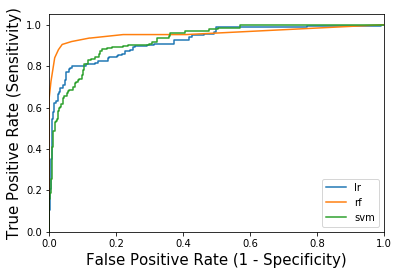

In [0]:
fpr_lr, tpr_lr, thresholds_lr = metrics.roc_curve(train_class_up, y_pred_prob_lr[:,1])
fpr_rf, tpr_rf, thresholds_rf = metrics.roc_curve(train_class_up, y_pred_prob_rf[:,1])
fpr_svm, tpr_svm, thresholds_svm = metrics.roc_curve(train_class_up, y_pred_prob_svm[:,1])
# plot LR model ROC curves
plt.plot(fpr_lr, tpr_lr,label="lr")
plt.plot(fpr_rf, tpr_rf,label="rf")
plt.plot(fpr_svm, tpr_svm,label="svm")
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize = 15)
plt.ylabel('True Positive Rate (Sensitivity)', fontsize = 15)

Text(0, 0.5, 'Precision')

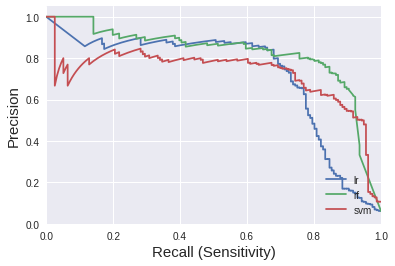

In [0]:
# calculate precision-recall curve
precision_lr, recall_lr, thresholds_pr_lr = metrics.precision_recall_curve(train_class_up, y_pred_prob_lr[:,1])
precision_rf, recall_rf, thresholds_pr_rf = metrics.precision_recall_curve(train_class_up, y_pred_prob_rf[:,1])
precision_svm, recall_svm, thresholds_pr_svm = metrics.precision_recall_curve(train_class_up, y_pred_prob_svm[:,1])

plt.plot(recall_lr, precision_lr, label='lr')
plt.plot(recall_rf, precision_rf, label='rf')
plt.plot(recall_svm, precision_svm, label='svm')

plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.legend(loc="lower right")
plt.xlabel('Recall (Sensitivity)', fontsize = 15)
plt.ylabel('Precision', fontsize = 15)

In [0]:
# plot best model with thresholds
plt.plot(fpr_lr, tpr_lr, label="lr")
plt.plot(fpr_lr, thresholds_lr, label="lr_thresh")
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.legend(loc="center")
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize= 15)
plt.ylabel('True Positive Rate (Sensitivity) or Class 1 Threshold Probability', fontsize = 15)

NameError: ignored

In [0]:
#create a predictions column for subesquent viz of TN, TP, FN, FP
def conf_mat_column(dataframe):
  preds = []
  for index, row in dataframe.iterrows():
      if (row['class'] == 0) & (row['class_lr'] == 0):
          pred = 'TN'
      if (row['class'] == 0) & (row['class_lr'] == 1):
          pred = 'FP'
      if (row['class'] == 1) & (row['class_lr'] == 1):
          pred = 'TP'
      if (row['class'] == 1) & (row['class_lr'] == 0):
          pred = 'FN'
          
      preds.append(pred)
      
  dataframe['pred'] = preds
  return dataframe

train_upsamples = conf_mat_column(train_upsamples)
train_upsamples.head()

,Unnamed: 0,animal_number,session,time_stamp,Annotation,0.0,0.48828125,0.9765625,1.46484375,1.953125,2.44140625,2.9296875,3.41796875,3.90625,4.39453125,4.8828125,5.37109375,5.859375,6.34765625,6.8359375,7.32421875,7.8125,8.30078125,8.7890625,9.27734375,9.765625,10.25390625,10.7421875,11.23046875,11.71875,12.20703125,12.6953125,13.18359375,13.671875,14.16015625,14.6484375,15.13671875,15.625,16.11328125,16.6015625,17.08984375,17.578125,18.06640625,18.5546875,19.04296875,19.53125,20.01953125,20.5078125,20.99609375,21.484375,21.97265625,22.4609375,22.94921875,23.4375,23.92578125,24.4140625,24.90234375,25.390625,25.87890625,26.3671875,26.85546875,27.34375,27.83203125,28.3203125,28.80859375,29.296875,29.78515625,30.2734375,30.76171875,31.25,31.73828125,32.2265625,32.71484375,33.203125,33.69140625,34.1796875,34.66796875,35.15625,35.64453125,36.1328125,36.62109375,37.109375,37.59765625,38.0859375,38.57421875,39.0625,39.55078125,40.0390625,40.52734375,41.015625,41.50390625,41.9921875,42.48046875,42.96875,43.45703125,43.9453125,44.43359375,44.921875,45.41015625,45.8984375,46.38671875,46.875,47.36328125,47.8515625,48.33984375,48.828125,49.31640625,49.8046875,50.29296875,50.78125,51.26953125,51.7578125,52.24609375,52.734375,53.22265625,53.7109375,54.19921875,54.6875,55.17578125,55.6640625,56.15234375,56.640625,57.12890625,57.6171875,58.10546875,58.59375,59.08203125,59.5703125,60.05859375,60.546875,61.03515625,61.5234375,62.01171875,62.5,62.98828125,63.4765625,63.96484375,64.453125,64.94140625,65.4296875,65.91796875,66.40625,66.89453125,67.3828125,67.87109375,68.359375,68.84765625,69.3359375,69.82421875,70.3125,70.80078125,71.2890625,71.77734375,72.265625,72.75390625,73.2421875,73.73046875,74.21875,74.70703125,75.1953125,75.68359375,76.171875,76.66015625,77.1484375,77.63671875,78.125,78.61328125,79.1015625,79.58984375,80.078125,80.56640625,81.0546875,81.54296875,82.03125,82.51953125,83.0078125,83.49609375,83.984375,84.47265625,84.9609375,85.44921875,85.9375,86.42578125,86.9140625,87.40234375,87.890625,88.37890625,88.8671875,89.35546875,89.84375,90.33203125,90.8203125,91.30859375,91.796875,92.28515625,92.7734375,93.26171875,93.75,94.23828125,94.7265625,95.21484375,95.703125,96.19140625,96.6796875,97.16796875,97.65625,98.14453125,98.6328125,99.12109375,99.609375,100.09765625,100.5859375,101.07421875,101.5625,102.05078125,102.5390625,103.02734375,103.515625,104.00390625,104.4921875,104.98046875,105.46875,105.95703125,106.4453125,106.93359375,107.421875,107.91015625,108.3984375,108.88671875,109.375,109.86328125,110.3515625,110.83984375,111.328125,111.81640625,112.3046875,112.79296875,113.28125,113.76953125,114.2578125,114.74609375,115.234375,115.72265625,116.2109375,116.69921875,117.1875,117.67578125,118.1640625,118.65234375,119.140625,119.62890625,120.1171875,120.60546875,121.09375,121.58203125,122.0703125,122.55859375,123.046875,123.53515625,124.0234375,124.51171875,125.0,class,pred_prob_lr,pred_prob_rf,pred_prob_svm,class_lr,pred
120,120,A12,D3,147037.5,bbc,4.361724,8.998940,10.173535,12.988050,17.756992,23.713041,29.567953,35.005135,41.095085,48.727074,57.352530,66.48759,78.010830,94.710180,115.332230,133.06555,142.09265,145.86410,155.53844,177.53691,204.34666,221.79124,226.43182,231.79071,253.21245,288.12460,317.62000,331.32970,346.90936,397.20618,494.39645,609.34380,690.15960,701.93170,648.84420,562.52814,476.02260,409.68530,372.86017,367.43930,386.51620,415.55713,441.15720,458.83940,469.66782,470.01227,448.85620,397.91860,323.57712,246.90367,190.88277,165.997210,165.33435,171.740570,171.084380,161.82072,153.435420,155.160430,165.65327,173.91672,169.95674,153.32870,131.47194,112.679085,103.75687,113.66336,154.48940,234.06100,346.24454,469.78560,577.90110,649.93884,676.39780,657.937100,604.61410,536.52985,479.61510,452.91446,455.586700,467.56390,466.590940,446.38583,417.762570,392.73030,370.47137,340.651800,297.934170,248.98840,204.722430,169.42622,140.186050,114.46130,93.87627,80.262856,71.876220,65.977480,63.019974,65.105710,70.720570,7

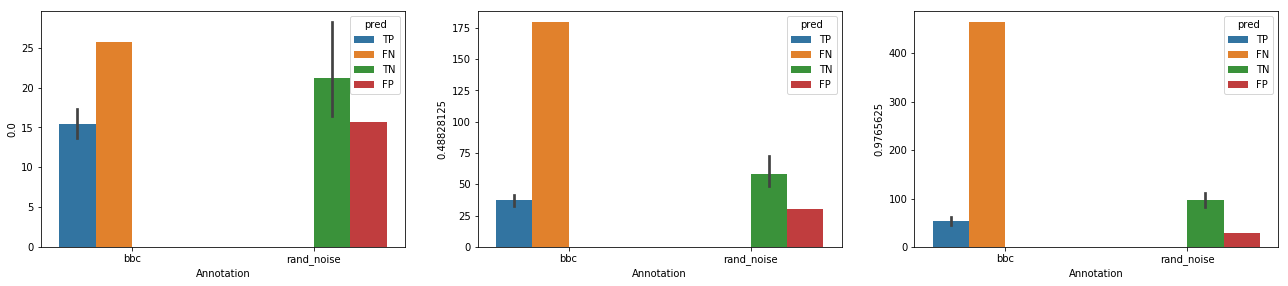

In [0]:
#viz of feature vs. pred group
feat_col = train_upsamples.loc[:, '0.0':'0.9765625']

i=1
plt.figure(figsize=(30,20))
for name in feat_col:
    plt.subplot(4, 4, i)
    sns.barplot(x="Annotation", y=name, hue="pred", data=train_upsamples)
    i = i + 1

In [0]:
false_neg_unique = train_upsamples[train_upsamples['pred'] == 'FN'].drop_duplicates()
false_neg_unique

,Unnamed: 0,animal_number,session,time_stamp,Annotation,0.0,0.48828125,0.9765625,1.46484375,1.953125,2.44140625,2.9296875,3.41796875,3.90625,4.39453125,4.8828125,5.37109375,5.859375,6.34765625,6.8359375,7.32421875,7.8125,8.30078125,8.7890625,9.27734375,9.765625,10.25390625,10.7421875,11.23046875,11.71875,12.20703125,12.6953125,13.18359375,13.671875,14.16015625,14.6484375,15.13671875,15.625,16.11328125,16.6015625,17.08984375,17.578125,18.06640625,18.5546875,19.04296875,19.53125,20.01953125,20.5078125,20.99609375,21.484375,21.97265625,22.4609375,22.94921875,23.4375,23.92578125,24.4140625,24.90234375,25.390625,25.87890625,26.3671875,26.85546875,27.34375,27.83203125,28.3203125,28.80859375,29.296875,29.78515625,30.2734375,30.76171875,31.25,31.73828125,32.2265625,32.71484375,33.203125,33.69140625,34.1796875,34.66796875,35.15625,35.64453125,36.1328125,36.62109375,37.109375,37.59765625,38.0859375,38.57421875,39.0625,39.55078125,40.0390625,40.52734375,41.015625,41.50390625,41.9921875,42.48046875,42.96875,43.45703125,43.9453125,44.43359375,44.921875,45.41015625,45.8984375,46.38671875,46.875,47.36328125,47.8515625,48.33984375,48.828125,49.31640625,49.8046875,50.29296875,50.78125,51.26953125,51.7578125,52.24609375,52.734375,53.22265625,53.7109375,54.19921875,54.6875,55.17578125,55.6640625,56.15234375,56.640625,57.12890625,57.6171875,58.10546875,58.59375,59.08203125,59.5703125,60.05859375,60.546875,61.03515625,61.5234375,62.01171875,62.5,62.98828125,63.4765625,63.96484375,64.453125,64.94140625,65.4296875,65.91796875,66.40625,66.89453125,67.3828125,67.87109375,68.359375,68.84765625,69.3359375,69.82421875,70.3125,70.80078125,71.2890625,71.77734375,72.265625,72.75390625,73.2421875,73.73046875,74.21875,74.70703125,75.1953125,75.68359375,76.171875,76.66015625,77.1484375,77.63671875,78.125,78.61328125,79.1015625,79.58984375,80.078125,80.56640625,81.0546875,81.54296875,82.03125,82.51953125,83.0078125,83.49609375,83.984375,84.47265625,84.9609375,85.44921875,85.9375,86.42578125,86.9140625,87.40234375,87.890625,88.37890625,88.8671875,89.35546875,89.84375,90.33203125,90.8203125,91.30859375,91.796875,92.28515625,92.7734375,93.26171875,93.75,94.23828125,94.7265625,95.21484375,95.703125,96.19140625,96.6796875,97.16796875,97.65625,98.14453125,98.6328125,99.12109375,99.609375,100.09765625,100.5859375,101.07421875,101.5625,102.05078125,102.5390625,103.02734375,103.515625,104.00390625,104.4921875,104.98046875,105.46875,105.95703125,106.4453125,106.93359375,107.421875,107.91015625,108.3984375,108.88671875,109.375,109.86328125,110.3515625,110.83984375,111.328125,111.81640625,112.3046875,112.79296875,113.28125,113.76953125,114.2578125,114.74609375,115.234375,115.72265625,116.2109375,116.69921875,117.1875,117.67578125,118.1640625,118.65234375,119.140625,119.62890625,120.1171875,120.60546875,121.09375,121.58203125,122.0703125,122.55859375,123.046875,123.53515625,124.0234375,124.51171875,125.0,class,pred_prob_lr,pred_prob_rf,pred_prob_svm,class_lr,pred
107,107,556,cagepair,41670.0,bbc,25.66847,179.82579,465.1402,708.22076,801.5353,802.1406,827.0844,911.8311,991.9273,1003.58844,963.72107,937.68005,951.7993,966.1278,932.9293,857.1891,783.5021,735.66516,693.0054,631.9065,572.72894,566.98254,638.071,746.7189,821.83105,826.1697,797.0607,829.28564,1007.2832,1324.6287,1653.2604,1814.9404,1726.5479,1491.7673,1325.4598,1358.3046,1514.7815,1598.045,1494.0474,1278.1494,1122.6416,1120.9427,1213.0194,1265.3965,1203.292,1069.8845,977.63416,1006.7361,1135.7015,1260.067,1283.7815,1198.584,1075.2986,989.9144,984.40125,1105.7275,1439.176,2036.1019,2780.4778,3362.8984,3453.146,2949.9692,2082.4631,1262.4165,807.82495,758.3398,911.0834,1021.9649,995.57874,913.53546,901.88495,984.76105,1072.3318,1078.2909,1018.5436,974.2757,973.19214,945.18256,816.9919,637.0704,576.5089,786.8048,1252.6251,1784.6876,2155.9775,2249.8044,2094.8206,1789.1411,1420.1302,1058.6692,791.0089,698.18256,776.58136,904.9904,938.0393,849.0973,755.7127,779.2333,892.30865,937.4788,802.2984,547.95575,344.05203,293.150

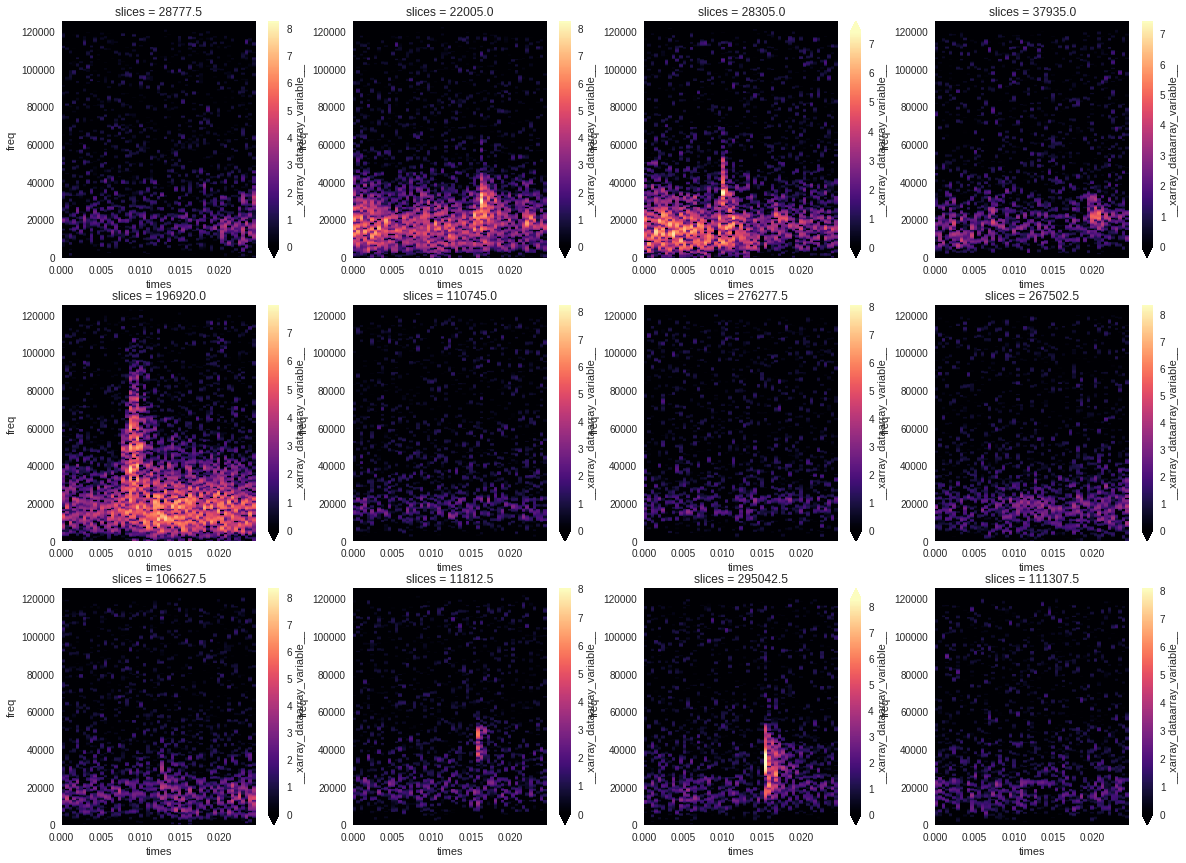

In [0]:
#viz for false negatives (need path for corresponding netcdf files)
netcdf_path_pain = '/content/gdrive/Team Drives/USV_eScience_Incubator/Data/netcdf_files/Fear'
false_neg_unique = train_upsamples[train_upsamples['pred'] == 'FN'].drop_duplicates()
dim = dim = np.int(np.ceil(np.sqrt(false_neg_unique.shape[0])))
i = 1
plt.figure(figsize=(dim*5,dim*5))
for index, row in false_neg_unique.iterrows():
    data = xr.open_dataset(str(netcdf_path_pain + '/' + row['session'] + '-' + row['animal_number'] + '-Pre_xr_Dataset.nc'))
    
    data_slice = data['__xarray_dataarray_variable__'].sel(slices=row['time_stamp'])
    times = data['times'].values
    freqs = data['freq'].values
    
    max_value = np.log(data.sel(slices=slice(67.5, 5.999625e+05)).max(xr.ALL_DIMS)['__xarray_dataarray_variable__'].values)
    #min_value = np.log(data.sel(slices=slice(67.5, 5.999625e+05)).min(xr.ALL_DIMS)['__xarray_dataarray_variable__'].values)
    
    plt.subplot(dim, dim, i)
    xr.ufuncs.log(data_slice).plot(cmap='magma', vmin=0, vmax = max_value*.7)
    
    i = i + 1

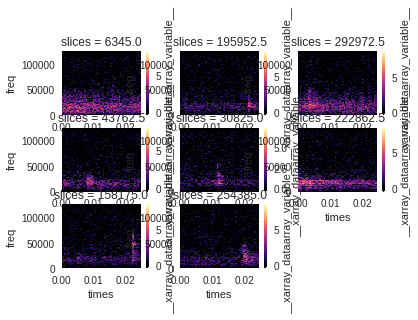

In [0]:
#viz for false positives (need path for corresponding netcdf files)
netcdf_path_pain = '/content/gdrive/Team Drives/USV_eScience_Incubator/Data/netcdf_files/Pain'
false_pos_unique = train_upsamples[train_upsamples['pred'] == 'FP'].drop_duplicates()
dim = dim = np.int(np.ceil(np.sqrt(false_pos_unique.shape[0])))
i = 1
plt.figure(figsize=(dim*5,dim*5))
for index, row in false_pos_unique.iterrows():
    data = xr.open_dataset(str(netcdf_path_pain + '/' + row['session'] + '-' + row['animal_number'] + '-Pre_xr_Dataset.nc'))
    
    data_slice = data['__xarray_dataarray_variable__'].sel(slices=row['time_stamp'])
    times = data['times'].values
    freqs = data['freq'].values
    
    max_value = np.log(data.sel(slices=slice(67.5, 5.999625e+05)).max(xr.ALL_DIMS)['__xarray_dataarray_variable__'].values)
    #min_value = np.log(data.sel(slices=slice(67.5, 5.999625e+05)).min(xr.ALL_DIMS)['__xarray_dataarray_variable__'].values)
    
    plt.subplot(dim, dim, i)
    xr.ufuncs.log(data_slice).plot(cmap='magma', vmin=0, vmax = max_value*.7)
    
    i = i + 1

In [0]:
#once you have decided on the model and hyperparameters, fit the model using the train data
svm_cv.fit(train_features_scaled, train_class_up) 

SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [0]:
#pickel model to save for later use
save_path = '/content/gdrive/Team Drives/USV_eScience_Incubator/Data/pickled_models/'


pkl_filename = str(save_path + "trained_pickle_model_painandCPA_PSD_100noise_svmstrat_noupsample.pkl")  
with open(pkl_filename, 'wb') as file:  
    pickle.dump(svm_cv, file)

In [0]:
#test model using test data and theshold of 0.5
print(svm_cv.score(test_features_scaled, test_class))
test_pred_rf = svm_cv.predict(test_features_scaled)
test_pred_prob_rf = svm_cv.predict_proba(test_features_scaled)
print(classification_report(test_class, test_pred_rf))
confusion_matrix(test_class, test_pred_rf)

0.9733210671573137
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1020
           1       0.73      0.90      0.81        67

   micro avg       0.97      0.97      0.97      1087
   macro avg       0.86      0.94      0.90      1087
weighted avg       0.98      0.97      0.97      1087



array([[998,  22],
       [  7,  60]])

In [0]:
#viz of feature vs. pred group
feat_col = ['power_sum', 'spec_pur', 'spec_cent', 'spec_spread', 'spec_skew',
       'spec_kurt', 'spec_slope', 'spec_roll', 'pred_prob_lr', 'pred_prob_rf',
       'pred_prob_svm']

i=1
plt.figure(figsize=(30,20))
for name in feat_col:
    plt.subplot(4, 4, i)
    sns.barplot(x="Annotation", y=name, hue="pred", data=test_features_scaled)
    i = i + 1

In [0]:
%%time
# This function can take a long to run
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2,  perplexity=50.0, n_iter=5000)
tsne_features = tsne.fit_transform(train_features_scaled)

NameError: ignored

In [0]:
print(tsne_features.shape)
tsne_df = pd.DataFrame(data = tsne_features, columns = ['tsne_0', 'tsne_1'], index = train_upsamples['Unnamed: 0'])
tsne_df['label'] = train_upsamples['class'].values
tsne_df['session'] = train_upsamples['session'].values
tsne_df['Annotation'] = train_upsamples['Annotation'].values
tsne_df.head()

(712, 2)


,tsne_0,tsne_1,label,session,Annotation
Unnamed: 0,,,,,
156,-36.815788,-1.251203,1,CPApair,low slug
23,35.714771,6.496996,1,D2,bbc
111,-36.561615,7.980228,1,CPApair,low slug
53,-47.909897,-16.369165,1,cagepair,high slug
168,30.043312,-27.183643,1,D4,bbc


Text(0.5, 1.0, 'Projection of the data on 2 components + ground truth labels')

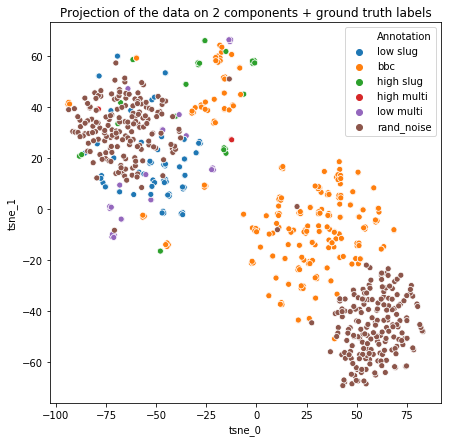

In [0]:
plt.figure(figsize=(7,7))
sns.scatterplot(x = 'tsne_0', y = 'tsne_1', hue = 'Annotation', data = tsne_df)
plt.title("Projection of the data on 2 components + ground truth labels")